# <font color = 'indianred'>**Multilabel Classification Using Llama-3.2-1B**

- The purpose of this notebook is to finetune the Llama-3.2-1B model for emotion detection on a small dataset.

- Based on my past experiences using RNN, BERT, and Gemma-2b models I plan on using a similar strategy to account for the class imbalance present in this dataset.

- This will be done using K fold stratified sampling to create my splits such that the class distribution represents that of the training set.

- In addition I plan on accounting for the class imbalance by calculating some class weights based on how they should be weighted individually within rather than across all classes.

- The training will follow a standard model training process as shown below.

## <font color='indianred'>**Training Plan**

1. **Set the Environment**

2. **Load the Dataset**

3. **Manipulate the Splits of the Dataset**

4. **Load the Pretrained Tokenizer**

5. **Create a Function for the Tokenizer**

6. **Train the Model**
   - 6.1. Download the model
   - 6.2. Download and modify the model's config file
   - 6.3. Compute the metric function (ensuring we account for multilabel, e.g., Binary Cross Entropy)
   - 6.4. Define Training Arguments
   - 6.5. Instantiate the Trainer
   - 6.6. Setup Weights & Biases (WANDB)
   - 6.7. Training and Validation

7. **Model Inference**

# <font color='indianred'>**1. Setting the Environment**</font>


In [ ]:
import sys

# Check if running in Google Colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    # Mount Google Drive with force_remount to avoid mounting issues
    drive.mount('/content/drive', force_remount=True)

    # Set the base path to a Google Drive folder
    base_path = '/content/drive/MyDrive/Colab Notebooks'

    # Install necessary packages
    print("Installing required libraries...")
    !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes -U -qq
    !pip install iterative-stratification -qq

    print("All packages installed successfully.")

Mounted at /content/drive
Installing required libraries...
All packages installed successfully.


In [ ]:
%load_ext autoreload
%autoreload 2

## <font color='indianred'>**Why Use `ninja-build` for Llama-3.2-1B Multilabel Fine-tuning in Colab**</font>

When fine-tuning a **large language model** like Llama-3.2-1B for **multilabel classification**, especially in Google Colab, optimizing your setup can significantly enhance performance. Here’s why adding `ninja-build` into the workflow can be beneficial:

### <font color='indianred'>**🚀 Speeding Things Up**</font>
- Llama-3.2-1B requires intensive computations, such as **compiling custom layers** and CUDA extensions.
- `ninja-build` focuses on efficiency—it **compiles code significantly faster** than traditional tools like `make`, reducing the overall setup time.

### <font color='indianred'>**🧩 Compatibility with Libraries**</font>
- Key libraries such as `transformers` and `peft` may **automatically utilize** `ninja-build` if it’s available, expediting their initialization process.
- For any **native code or CUDA optimizations** involved in fine-tuning, `ninja-build` can provide a noticeable boost.

### <font color='indianred'>**🛠️ Ensuring Stability**</font>
- Fine-tuning substantial models like Llama-3.2-1B can strain system resources. Leveraging `ninja-build` helps maintain **stability**, minimizing potential compile-time errors or bottlenecks.

### <font color='indianred'>**How to Install It**</font>
```bash
!apt-get install -y ninja-build


In [ ]:
!apt-get install -y ninja-build

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ninja-build is already the newest version (1.10.1-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
# Standard libraries and sklearn imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    confusion_matrix,
    multilabel_confusion_matrix,
    precision_score,
    recall_score,
    f1_score
    )

from pathlib import Path
import numpy as np

import re
import gc
import time

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import joblib

# Huggingface, evaluate, wandb, torch, bitsandbytes, transformers
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import (
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    AutoModelForSequenceClassification,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
    set_seed,
    DataCollatorWithPadding
    )

from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model
)

import wandb
from google.colab import userdata
from huggingface_hub import login
import torch.nn as nn
import ast
import torch

In [ ]:
set_seed(42)

In [ ]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')

In [ ]:
if hf_token:
  login(token = hf_token)
  print('Login Successful')
else:
  print('HF login not unsuccessful - Missing token')


Login Successful


In [ ]:
if wandb_api_key:
  wandb.login(key = wandb_api_key)
  print('Login Successful')
else:
  print('Login Unsuccessful')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: the-steven-e (the-steven-e-the-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Login Successful


In [ ]:
base_folder = Path(base_path)
data_folder = base_folder/'datasets/emotion_detection_ds'
model_folder = base_folder/'models/nlp_fall_2024/LLama-3.2-1B'

model_folder.mkdir(exist_ok = True, parents = True)

# <font color='indianred'>**2. Loading the Dataset**</font>


In [ ]:
train_valid_df = pd.read_csv(data_folder/'train.csv')
train_valid_df.head(5)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
train_val_labels = train_valid_df[['anger',
                                      'anticipation',
                                             'disgust',
                                             'fear',
                                             'joy',
                                             'love',
                                             'optimism',
                                             'pessimism',
                                             'sadness',
                                             'surprise',
                                             'trust']]

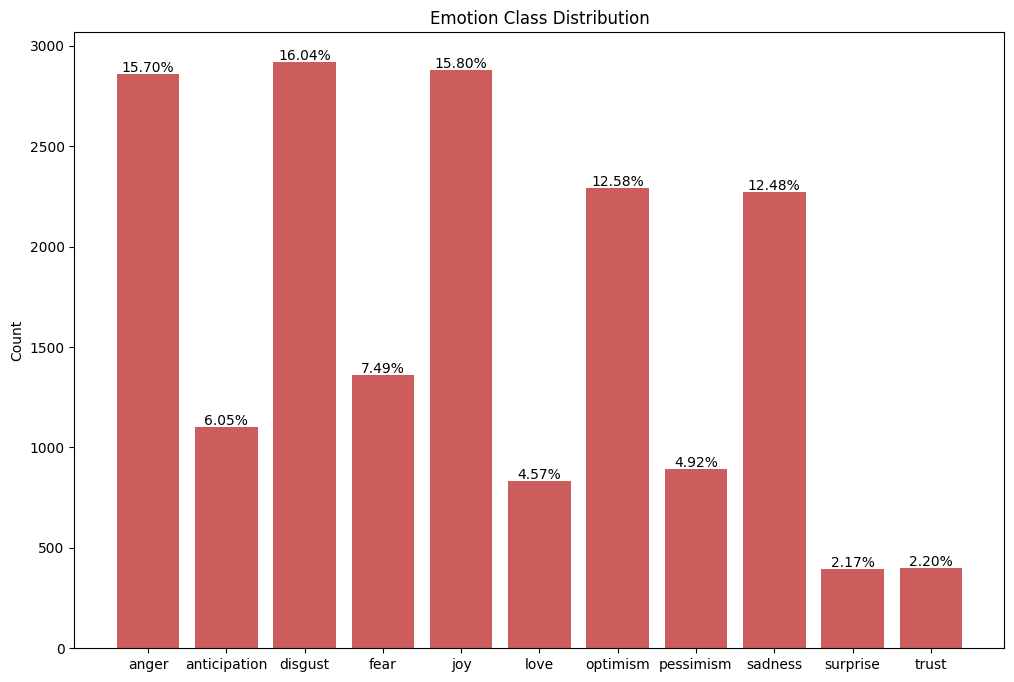

In [ ]:
# Getting the count of each label
label_counts = train_val_labels.sum()

# getting the sum of all labels
total_counts = label_counts.sum()

# getting the percentages for each label
percentages = (label_counts/total_counts)*100

# plotting a bar plot for the count of each label
plt.figure(figsize = (12,8))
plt.bar(label_counts.index, label_counts.values, color = 'indianred')

for i, (count, pct) in enumerate(zip(label_counts.values, percentages)):
  plt.text(i, count+10, f'{pct:.2f}%', ha= 'center')

plt.title('Emotion Class Distribution')
plt.ylabel('Count')
plt.show()

In [ ]:
label_counts

,0
anger,2859
anticipation,1102
disgust,2921
fear,1363
joy,2877
love,832
optimism,2291
pessimism,895
sadness,2273
surprise,396


# <font color='indianred'>**3. Splitting and Preparing the Data**</font>




<font color = 'indianred'>***Applying Multilabel Stratified KFold***

In [ ]:
mkf = MultilabelStratifiedKFold(n_splits = 10, shuffle = True, random_state = 42) # shuffling and doing 10 splits

X = train_valid_df['Tweet'].values
y = train_val_labels.values

# designating the inices for the training and validation split
for train_index, val_index in mkf.split(X, y):
  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

In [ ]:
# reformatting to a dataframe
train_df = train_valid_df.iloc[train_index] # pulling the train indices from the split into the training df
val_df = train_valid_df.iloc[val_index] # pulling the valid indices from the split into the val_df


In [ ]:
train_df.head(5)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
val_df.tail()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
7687,2018-03658,That was absolutely the two worst National Ant...,1,0,1,0,0,0,0,1,1,0,0
7693,2018-03875,Everything I order online just comes looking l...,1,0,1,0,0,0,0,0,0,0,0
7698,2018-03846,Some 'friends' get bitter when it seems your l...,0,0,1,0,0,0,0,1,1,0,0
7707,2018-03005,"@ThomasSanders This was great, looking forward...",0,0,0,0,1,0,1,0,0,0,0
7710,2018-01302,@kamaalrkhan Which #chutiya #producer #investe...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
train_labels = train_df[['anger',
                         'anticipation',
                         'disgust',
                         'fear',
                         'joy',
                         'love',
                         'optimism',
                         'pessimism',
                         'sadness',
                         'surprise',
                         'trust']]

In [ ]:
train_labels.sum()

,0
anger,2574
anticipation,991
disgust,2629
fear,1226
joy,2589
love,749
optimism,2062
pessimism,805
sadness,2046
surprise,356


### <font color='indianred'>*The plots below shows how the stratified sampling split properly represents the full training set.*</font>

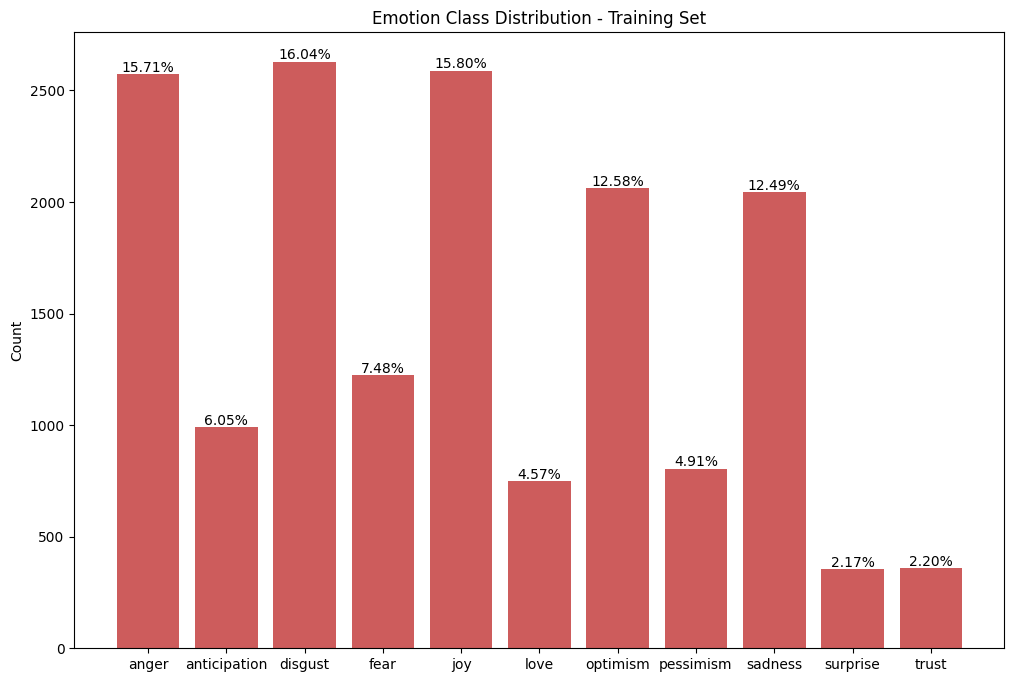

In [ ]:
# plotting of the class distribution for the train_df
label_counts_t = train_labels.sum()

# total counts for the training df
total_counts_t = label_counts_t.sum()

# percentages for the train_df labels
percentages_t = (label_counts_t/total_counts_t)*100

# plotting the bar plot
plt.figure(figsize = (12,8))
plt.bar(label_counts_t.index, label_counts_t.values, color = 'indianred')

for i, (count, pct) in enumerate(zip(label_counts_t.values, percentages_t)):
  plt.text(i, count+10, f'{pct:.2f}%', ha = 'center')

plt.title('Emotion Class Distribution - Training Set')
plt.ylabel('Count')
plt.show()



In [ ]:
val_labels = val_df[['anger',
                         'anticipation',
                         'disgust',
                         'fear',
                         'joy',
                         'love',
                         'optimism',
                         'pessimism',
                         'sadness',
                         'surprise',
                         'trust']]

In [ ]:
val_labels.sum()

,0
anger,285
anticipation,111
disgust,292
fear,137
joy,288
love,83
optimism,229
pessimism,90
sadness,227
surprise,40


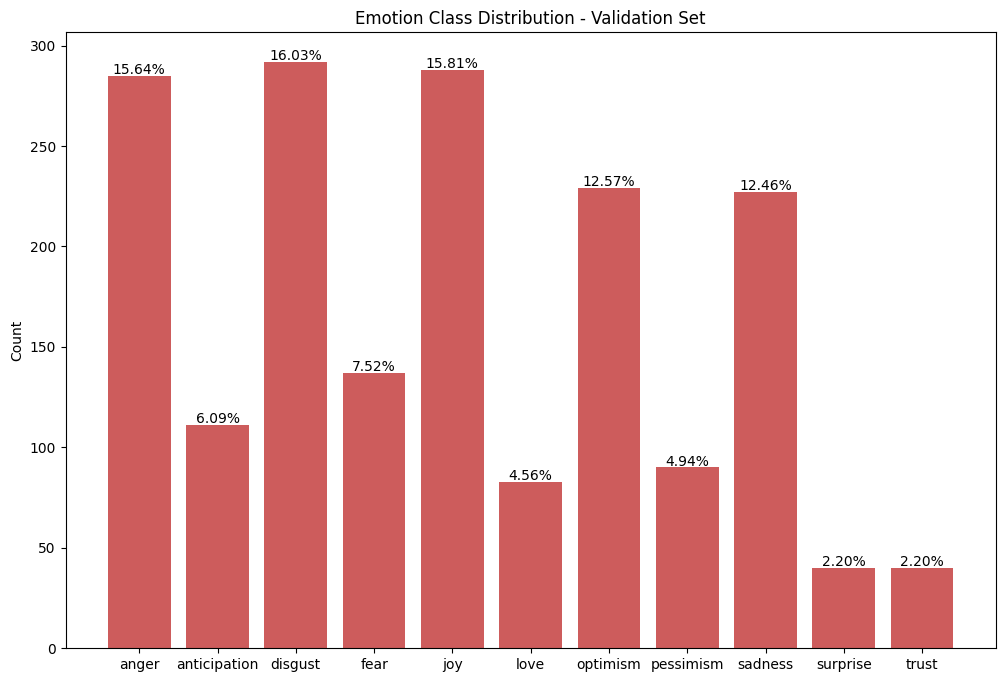

In [ ]:
# getting the counts of the labels for the validation set
label_counts_v = val_labels.sum()

# total counts
total_counts_v = label_counts_v.sum()

# percentages
percentages_v = (label_counts_v/total_counts_v)*100

# plotting the bar graph for the distribution
plt.figure(figsize = (12,8))
plt.bar(label_counts_v.index, label_counts_v.values, color = 'indianred')

for i, (count, pct) in enumerate(zip(label_counts_v.values, percentages_v)):
  plt.text(i, count+1, f'{pct:.2f}%', ha = 'center')

plt.title('Emotion Class Distribution - Validation Set')
plt.ylabel('Count')
plt.show()

<font color = 'indianred'>*Checking the datatypes of X_train and y_train and converting to list for use in dataframe.*

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
X_train = X_train.tolist()
X_val = X_val.tolist()

In [ ]:
X_val[0]

'Do you think humans have the sense for recognizing impending doom? '

<font color = 'indianred'>***Initial Datasets***

In [ ]:
trainset = Dataset.from_dict({
    'text':X_train, 'label':y_train
})

validset = Dataset.from_dict({
    'text':X_val, 'label':y_val
})

In [ ]:
trainset

Dataset({
    features: ['text', 'label'],
    num_rows: 6951
})

In [ ]:
trainset['text'][0:5]

["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'Whatever you decide to do make sure it makes you #happy.',
 "@Max_Kellerman  it also helps that the majority of NFL coaching is inept. Some of Bill O'Brien's play calling was wow, ! #GOPATS",
 "Accept the challenges so that you can literally even feel the exhilaration of victory.' -- George S. Patton 🐶",
 "My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs"]

In [ ]:
trainset['label'][:5]

[[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
validset

Dataset({
    features: ['text', 'label'],
    num_rows: 773
})

In [ ]:
validset['text'][3:5]

["@WaterboysAS I would never strategically vote for someone I don't agree with. A lot of the Clinton vote based on fear and negativity.",
 "@imtarakate Uggh that's really horrible. You're not a bad person by any stretch of the imagination. I hope this person realizes that."]

In [ ]:
validset['label'][3:5]

[[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]]

<font color = 'indianred'>***Final Dataset***

In [ ]:
train_val = DatasetDict({'train':trainset, 'valid':validset})

In [ ]:
train_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6951
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 773
    })
})

In [ ]:
train_val['train']['text'][:5]

["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'Whatever you decide to do make sure it makes you #happy.',
 "@Max_Kellerman  it also helps that the majority of NFL coaching is inept. Some of Bill O'Brien's play calling was wow, ! #GOPATS",
 "Accept the challenges so that you can literally even feel the exhilaration of victory.' -- George S. Patton 🐶",
 "My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs"]

In [ ]:
train_val['train']['label'][:5]

[[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
train_val['valid']['text'][3:5]

["@WaterboysAS I would never strategically vote for someone I don't agree with. A lot of the Clinton vote based on fear and negativity.",
 "@imtarakate Uggh that's really horrible. You're not a bad person by any stretch of the imagination. I hope this person realizes that."]

In [ ]:
train_val['valid']['label'][3:5]

[[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]]

# <font color='indianred'>**4. Initializing the Pretrained Tokenizer**</font>




## <font color='indianred'>**Loading the LLAMA-3.2-1B tokenizer**

### The difference between BERT and a QLoRA model:
- **BERT** (Bidirectional Encoder Representations from Transformers) is a transformer-based model that focuses on two key tasks:
  - **Masked Language Modeling**: BERT randomly masks 15% of tokens in the input sequence, and the model learns to predict the masked tokens, which helps it understand context better.
  - **Next Sentence Prediction**: BERT is trained to predict whether two sentences follow each other in a given pair (e.g., "Is sentence A followed by sentence B?").
  - BERT can handle many different tasks, but these two are the main pretraining objectives.

- **QLoRA** (Quantized Low-Rank Adaptation):
  - QLoRA is an efficient, lightweight approach to fine-tuning LLM's using quantized weights and low-rank adaptors.
    - <font color = 'indianred'>**Quantization**</font> reduces the precision of values by changing the way numbers are used within the model.
    - Standard models use 32-bit floating point numbers to represent the weights of a model.
    - Quantized weights are represented in lower formats such as 8-bit or 4-bit representations.
      - By using fewer bits to store the same data, quantization allows models to:
        - Use less memory
        - Run faster on existing hardware
        - Consume less power, which makes them more efficient for deployment.
    - QLoRA, in particular, uses 4-bit quantization to compress LLM's while maintaining performance at the same time.
      - This means we can fit a large language model into the memory of a 24GB GPU!
    - <font color = 'indianred'>**Low Rank adaptation**</font> works by freezing the original model weights.
      - Instead of taking the entire weight matrix from the original model we fine tune two smaller matrices of weights and add them to the original weight matrix.
      - Example:

        Weights = Main_weights + Small_matrix_A*Small_matrix_B

        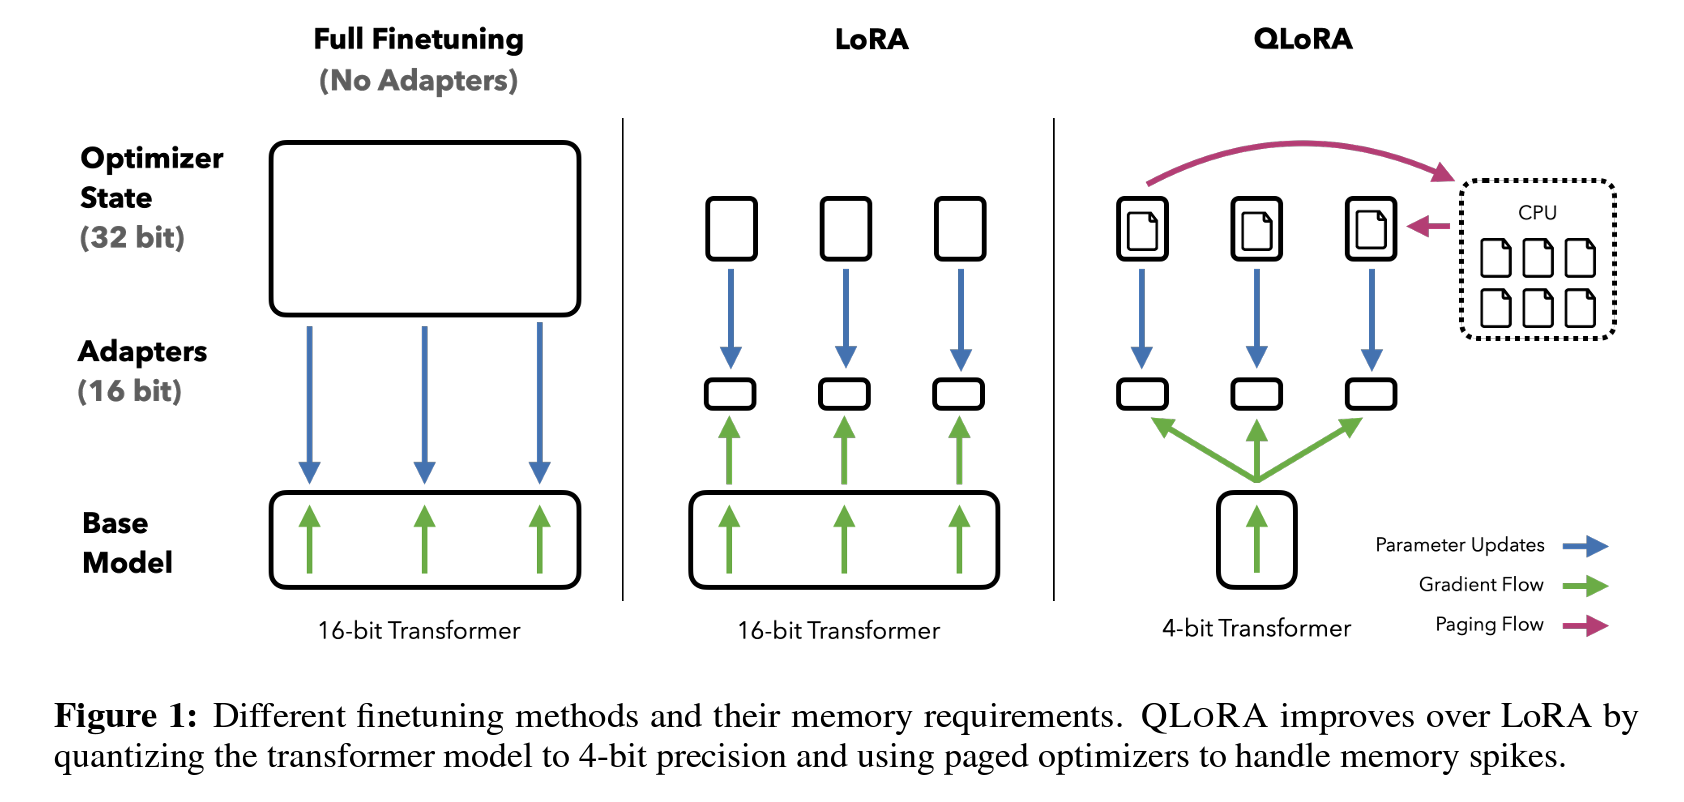

      [Original QLoRA Paper](https://arxiv.org/abs/2305.14314)
      - This allows for a finetuning process that is much smaller and efficient.
      



In [ ]:
def free_gpu_memory():
  """
  Frees up gpu memory after CUDA out of memory error in Colab.

  This function performs the following steps:
  1. Deletes all pytorch objects.
  2. Calls garbage collection to remove unreferenced objects.
  3. Uses torch.cuda.empy_cache() to release cached GPU memory
  4. Waits for a moment to ensure memory is fully released.
  """

  try:
    # Delete all torch tensors to free uo memory
    for obj in list(locals().values()):
      if torch.is_tensor(obj):
        del obj

    # collecting garbage to release any remaining unused memory
    gc.collect()

    # empty the CUDA chache to release GPU memory
    torch.cuda.empty_cache()

    # adding a small delay to allow memory to be fully released
    time.sleep(2)

    print("GPU memory has been freed.")
  except Exception as e:
    print(f"Error while freeing GPU memory: {e}")

In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
checkpoint = 'meta-llama/Llama-3.2-1B'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# <font color='indianred'>**5. Creating the Tokenization Function**</font>




In [ ]:
tokenizer.pad_token = '<|finetune_right_pad_id|>'

In [ ]:
def tokenize_fn(batch):
  return tokenizer(text = batch['text'], truncation = True, max_length = 512)

### <font color='indianred'>**Remapping labels to float**</font>

In [ ]:
tokenized_dataset = train_val.map(tokenize_fn, batched = True)
tokenized_dataset = tokenized_dataset.remove_columns(['text'])

tokenized_dataset.set_format(type = 'torch')

Map:   0%|          | 0/6951 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset = (tokenized_dataset
                     .map(lambda x: {'float_label':x['label'].to(torch.float)}, remove_columns = ['label'])
                     .rename_column('float_label', 'label'))

Map:   0%|          | 0/6951 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset['train']['label'][0:5]

tensor([[0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

# <font color='indianred'>**6. Training the Model**</font>

## <font color='indianred'>**6.1 Downloading the Model**</font>


### Optimizing Data Type for My GPU

This function picks the best data type (`dtype`) for my model based on the GPU I'm using. If I’ve got a newer GPU (compute capability `8.0` or higher), it’ll use `bfloat16` for faster and more efficient training. Otherwise, it falls back to `float16`. This helps squeeze the best performance out of whatever hardware I’m running on.


In [ ]:
def get_appropriate_dtype():
  if torch.cuda.is_available() and torch.cuda.get_device_capability(0)>=(8,0):
    return torch.bfloat16
  return torch.float16

In [ ]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = 'nf4',
    bnb_4bit_use_double_quant = True,
    bnb_4bit_compute_dtype = torch_data_type,
    bnb_4bit_quant_storage = torch_data_type,

)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type = 'multi_label_classification',
                                                           quantization_config = bnb_config,
                                                           torch_dtype = torch_data_type,
                                                           trust_remote_code = True, )

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## <font color='indianred'>**6.2 Modifying the Model Configuration**</font>


In [ ]:
class_names = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [ ]:
config = AutoConfig.from_pretrained(checkpoint)
id2label = {id_:label_ for id_, label_ in enumerate(class_names)}
label2id = {label_:id_ for id_, label_ in enumerate(class_names)}

config.id2label = id2label
config.label2id = label2id
model.config = config
model.config.pad_token_id = tokenizer.pad_token_id

### <font color='indianred'>**Breakdown of `LlamaConfig`**</font>

Here's a quick breakdown of the configuration settings for the **Llama-3.2-1B** model based on your configuration file. This highlights how the **Llama model** is structured and optimized:

- **Model Architecture**: Uses `LlamaForCausalLM`, which is set up for **causal language modeling**, ideal for text generation tasks.

---

### <font color='indianred'>**Attention**</font>
- **No bias terms** in the attention layers (`attention_bias: false`).
- **No dropout** applied to attention layers (`attention_dropout: 0.0`).
- **32 attention heads** with **8 key-value heads**, providing a **high level of granularity** in processing different parts of the input.
- **Head dimension**: 64

---

### <font color='indianred'>**Tokens & Vocabulary**</font>
- **Token IDs**:
  - `bos_token_id`: 128000 (Beginning of sentence)
  - `eos_token_id`: 128001 (End of sentence)
  - `pad_token_id`: 128004 (Padding)
- **Vocabulary size**: 128,256 tokens

---

### <font color='indianred'>**Model Size & Layers**</font>
- **Hidden size**: 2048
- **Intermediate size**: 8192 (feed-forward layer)
- **Number of layers**: 16

---

### <font color='indianred'>**Positional Embeddings**</font>
- **Max position embeddings**: 131,072 (supports extremely long sequences).
- Uses **rotary position embeddings** with `rope_theta: 500,000.0` for improved context handling in long sequences.
- **Rope scaling**:
  - Factor: 32.0
  - **High-frequency scaling**: 4.0
  - **Low-frequency scaling**: 1.0
  - Original max position embeddings: 8,192

---

### <font color='indianred'>**Activation, Initialization & Normalization**</font>
- **Activation function**: `silu` (Sigmoid Linear Unit).
- **Weight initialization range**: 0.02 (helps stabilize training).
- **RMS normalization** with epsilon (`rms_norm_eps: 1e-5`) for better layer stability.

---

### <font color='indianred'>**Caching & Efficiency**</font>
- **Caching enabled** (`use_cache: true`) to speed up inference.
- Uses **mixed precision** with `torch_dtype: bfloat16` for optimized GPU memory usage.

---

### <font color='indianred'>**Multilabel Classification Labels**</font>
- The model is configured for **11 emotion labels**:
  - **anger**, **anticipation**, **disgust**, **fear**, **joy**, **love**, **optimism**, **pessimism**, **sadness**, **surprise**, **trust**.
- Label mapping:
  - `id2label` and `label2id` dictionaries are used for **mapping labels** to their corresponding indices.

---

This configuration ensures that **Llama-3.2-1B** is optimized for **large-scale text generation** and **multilabel classification**, with a focus on handling long contexts efficiently and utilizing the latest architectural enhancements for speed and accuracy.


In [ ]:
model.config

LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp"

<font color = 'indianred'>***Peft Setup***

In [ ]:
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((20

In [ ]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [ ]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'score']


['down_proj',
 'gate_proj',
 'up_proj',
 'o_proj',
 'k_proj',
 'q_proj',
 'v_proj',
 'score']

In [ ]:
peft_config = LoraConfig(
    task_type = TaskType.SEQ_CLS,
    r = 128,
    lora_alpha = 256,
    lora_dropout = 0.01,
    bias = 'all',
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj']
)

In [ ]:
lora_model = get_peft_model(model, peft_config)

# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 90,200,064 || all params: 1,326,036,992 || trainable%: 6.8022


In [ ]:
lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
         

In [ ]:
for name, param in lora_model.named_parameters():
  print(f'{name}:{param.requires_grad}')

base_model.model.model.embed_tokens.weight:False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight:False
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight:True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight:True
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight:False
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight:True
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight:True
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight:False
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight:True
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight:True
base_model.model.model.layers.0.self_attn.o_proj.base_layer.weight:False
base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight:True
base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight:True
base_model.model.model.layers.0.mlp.gate_proj.base_

## <font color='indianred'>**6.3 Defining the Compute-Metric Function**</font>


In [ ]:
# loading the training metrics
accuracy = evaluate.load('accuracy', 'multilabel')
accuracy_flatten = evaluate.load('accuracy')
f1 = evaluate.load('f1', 'multilabel')

def compute_metrics(eval_pred):

  # pulling out the logits and labels from eval_pred
  logits, labels = eval_pred
  # getting the predictions as any logit above 0
  preds = (logits>0).astype(int)
  # getting the accuracy for the individual labels
  accuracy_label = accuracy_flatten.compute(predictions = preds.flatten(), references = labels.flatten())
  # getting the accuracy across all labels
  accuracy_all = accuracy.compute(predictions = preds, references = labels) # no flattening here to get the overall accuracy
  # getting the micro f1 based on individual labels
  f1_micro = f1.compute(predictions = preds, references = labels, average = 'micro')
  # getting the macro f1 for the score across all labels
  f1_macro = f1.compute(predictions = preds, references = labels, average ='macro')

  return {
      'f1_micro':f1_micro['f1'],
      'f1_macro':f1_macro['f1'],
      'accuracy_label': accuracy_label['accuracy'],
      'accuracy_all': accuracy_all['accuracy']
  }

## <font color='indianred'>**6.4 Setting Up Training Arguments**</font>


In [ ]:
# Using the same training arguments as I used in my last model
run_name= 'Llama-3.2-1B-QLoRa-emotion-exp1'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16
# Configure training parameters
training_args = TrainingArguments(
    seed = 42,  # question of life
    num_train_epochs=3,  # training epochs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps = 2,  # if you get an out of memory error try changing gradient accumulation and per device batch
    # we need the value to be 32 so we could do 8 batch size and 4 grad accumulation steps
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # Use non-reentrant checkpointing for better stability; avoids errors in complex models but may slightly slow down training

    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=5e-5,  # Increase learning rate for more aggressive updates
    optim='adamw_torch',  # Optimizer

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=50,  # Perform evaluation every 50 training steps for more stable evaluations
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=50,  # Save a model checkpoint every 50 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    metric_for_best_model="eval_f1_macro",  # Continue using F1 Macro as the key metric
    greater_is_better=True,  # A model is 'better' if its F1 Macro score is higher
    lr_scheduler_type = 'linear',
    warmup_steps = 300, # Warmup in 300 steps

    # Experiment logging configurations
    logging_strategy='steps',
    logging_steps=50,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16 = use_fp16, # set True if torch_data_type is torch.float16
    bf16 = use_bf16, # ste Treu if torch_data_type is torch.bfloat16
    tf32 = False, # disable tf32 unless you want to use Ampere specific optimization
)

In [ ]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    lora_model.config.use_cache = False  # Disable caching for compatibility

lora_model.config

LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp"

## <font color='indianred'>**6.5 Instantiating the Trainer**</font>


<font color= 'indianred'>***Function: `calculate_class_weights`***

This function calculates class weights for a multilabel classification task, treating each label as if it were a separate binary classification problem. The goal is to adjust for class imbalance **_without having the weights of one class affect the others_**, which can be a common issue when calculating class weights holistically across all labels.

<font color= 'indianred'>***Why this approach?***

In a multilabel setting, each label is independent, and an instance can belong to multiple classes simultaneously. Therefore, treating each label as a separate binary classification problem allows us to adjust the training focus for underrepresented labels without influencing the weights of other labels.

The weights are calculated as follows:
- <span style="color: indianred;">**Positive weight**</span> for each label = (total number of negatives) / (total number of positives).
- This means that if a label is less frequent (i.e., has fewer positive samples), its weight will be higher, encouraging the model to pay more attention to it during training.
- The function outputs these weights as a tensor, which can be used directly in the model's loss function (e.g., using `pos_weight` in `BCEWithLogitsLoss`).

<font color= 'indianred'>***Code Explanation***

- The function first initializes counters for positive and negative samples for each label.
- It iterates through the training dataset to count the number of positives and negatives for each label index.
- Finally, it computes the weight for each label as the ratio of negatives to positives, ensuring that the denominator is at least 1 to avoid division by zero.
- The resulting list of weights is returned as a **<span style="color: indianred;">PyTorch tensor</span>**, which can be used during model training to handle class imbalance.

In [ ]:
def calculate_pos_weights(dataset):
  # intitialize counters for all labels
  num_labels = len(dataset['train']['label'][0])
  total_positives = [0]*num_labels # empty list
  total_negatives = [0]*num_labels # empty list

  # counting the positives and negatives for each label
  for label_array in dataset['train']['label']:
    for i, label in enumerate(label_array):
      if label == 1:
        total_positives[i] +=1
      else:
        total_negatives[i]+=1
  # calculate the class weight for each label
  pos_weight = [total_negatives[i]/max(total_positives[i], 1) for i in range(num_labels)]
  return torch.tensor(pos_weight)

In [ ]:
pos_weights = calculate_pos_weights(tokenized_dataset)

In [ ]:
pos_weights

tensor([ 1.7005,  6.0141,  1.6440,  4.6697,  1.6848,  8.2804,  2.3710,  7.6348,
         2.3974, 18.5253, 18.3083])

<font color = 'indianred'>*Important to note here that these weights differ significantly from those in my last models. This is because my approach was to broadly calculate class weights against the other labels instead of interiorly as I have done above.*

In [ ]:
class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs = False, num_items_in_batch = None):
    labels = inputs.pop('labels').float() # float for BCE loss function
    outputs = model(**inputs)
    logits = outputs.get('logits')

    device = next(model.parameters()).device

    loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
    loss = loss_fct(logits, labels)

    return (loss, outputs) if return_outputs else loss # returns the loss and outputs if return_outputs=True else returns just the loss

<font color = 'indianred'>*Notice we need a collator for this model becuase sequences are not the same length.*

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

In [ ]:
trainer = CustomTrainer(
    model = lora_model,
    args = training_args,
    train_dataset = tokenized_dataset['train'],
    eval_dataset = tokenized_dataset['valid'],
    compute_metrics = compute_metrics,
    tokenizer = tokenizer,
    data_collator = data_collator
)

<ipython-input-71-6bd281c4fbe0>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


## <font color='indianred'>**6.6 Configuring Weights & Biases (WANDB)**</font>


In [ ]:
%env WANDB_PROJECT = emotion_llama_1B_multilabel

env: WANDB_PROJECT=emotion_llama_1B_multilabel


## <font color='indianred'>**6.7 Executing Training and Validation**</font>


In [ ]:
try:
  # may have an out of memory error
  # lora_model.config.use_cache = False
  trainer.train()
except RuntimeError as e:
  if 'CUDA out of memory' in str(e):
    print('CUDE out of memory error detected. Freeing GPU memory.')
    free_gpu_memory()
    # can optionally retry the operation after freeing up memory
    # trainer.train()
  else:
    raise e

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy Label,Accuracy All
50,1.524900,1.293355,0.324445,0.293414,0.538163,0.000000
100,1.129800,0.939838,0.486515,0.454078,0.652946,0.005175
150,0.894100,0.790098,0.554859,0.513698,0.732800,0.024580
200,0.771500,0.758774,0.607286,0.560339,0.780666,0.063389
250,0.721900,0.755443,0.605053,0.558379,0.779372,0.056921
300,0.672400,0.770892,0.625862,0.570425,0.789368,0.058215
350,0.659500,0.728488,0.614990,0.560283,0.787957,0.054334
400,0.656100,0.732871,0.663868,0.596731,0.830530,0.134541
450,0.604100,0.726676,0.662018,0.594050,0.829002,0.142303
500,0.448400,0.819493,0.658122,0.588801,0.827473,0.126779


In [ ]:
eval_results = trainer.evaluate(tokenized_dataset['valid'])

In [ ]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"], "eval_loss": eval_results["eval_loss"], "eval_accuracy": eval_results["eval_accuracy_all"]})

In [ ]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(tokenized_dataset['valid'])

# getting the probabilities from the logits
valid_logits = valid_output.predictions
# converting to probabilities using the sigmoid function
valid_probs = sigmoid(valid_logits)
# getting the labels as integers
valid_labels = np.array(valid_output.label_ids.astype(int))

In [ ]:
valid_logits.shape

(773, 11)

In [ ]:
valid_probs.shape

(773, 11)

In [ ]:
valid_labels.shape

(773, 11)

In [ ]:
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics

In [ ]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)

In [ ]:
optimal_thresholds

[0.48483747243881226,
 0.5900707244873047,
 0.3688603937625885,
 0.5688948631286621,
 0.5191556215286255,
 0.7606245875358582,
 0.5569964647293091,
 0.7476159334182739,
 0.5642171502113342,
 0.6217644214630127,
 0.3886205554008484]

In [ ]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [ ]:
compute_metrics((valid_logits, valid_labels), optimal_thresholds)

{'f1_micro': 0.7087576374745418,
 'f1_macro': 0.6217100450414972,
 'accuracy_label': 0.8654592496765847,
 'accuracy_all': 0.2147477360931436}

<font color = 'indianred'>*Simple Confusion Matrix*

In [ ]:
valid_preds = (valid_probs>optimal_thresholds).astype(int) # getting the predictions as the values with probabilities higher than the optimal thresholds
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
mcm

array([[[422,  66],
        [ 35, 250]],

       [[586,  76],
        [ 59,  52]],

       [[375, 106],
        [ 40, 252]],

       [[598,  38],
        [ 32, 105]],

       [[417,  68],
        [ 39, 249]],

       [[653,  37],
        [ 29,  54]],

       [[456,  88],
        [ 39, 190]],

       [[626,  57],
        [ 46,  44]],

       [[469,  77],
        [ 67, 160]],

       [[705,  28],
        [ 20,  20]],

       [[660,  73],
        [ 24,  16]]])

In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Reds',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Reds')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats

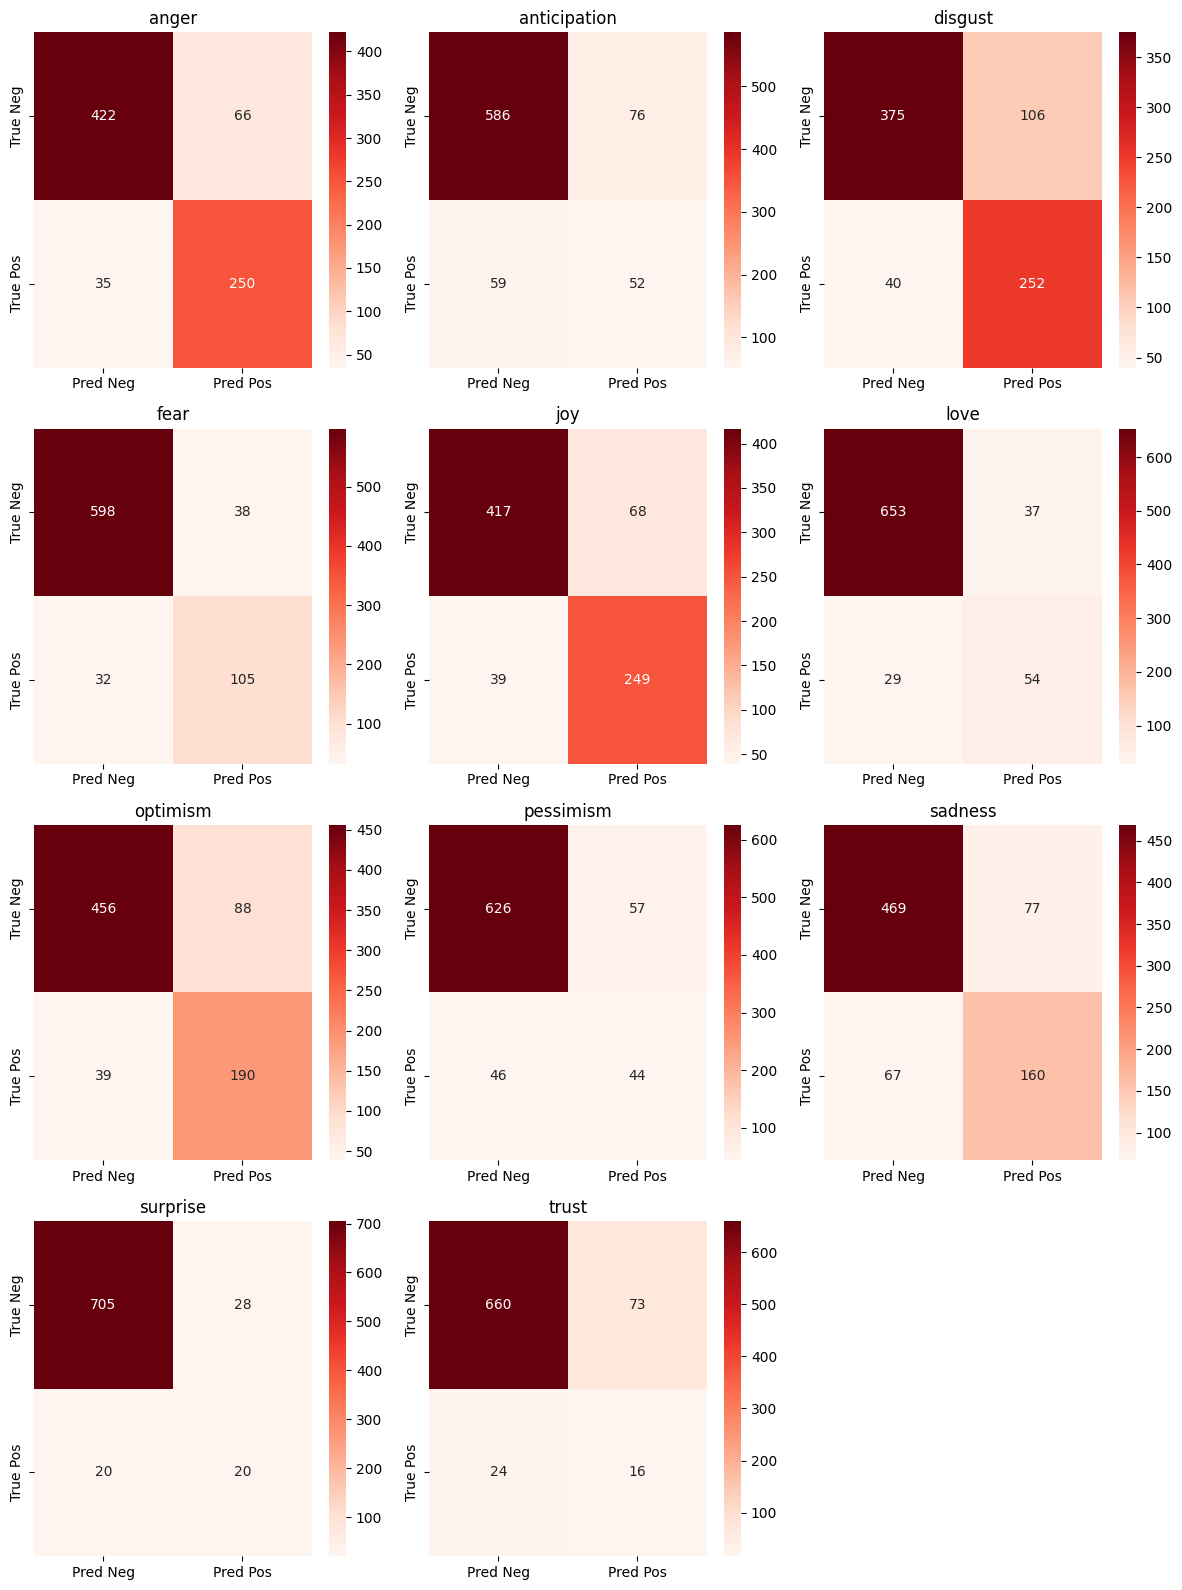

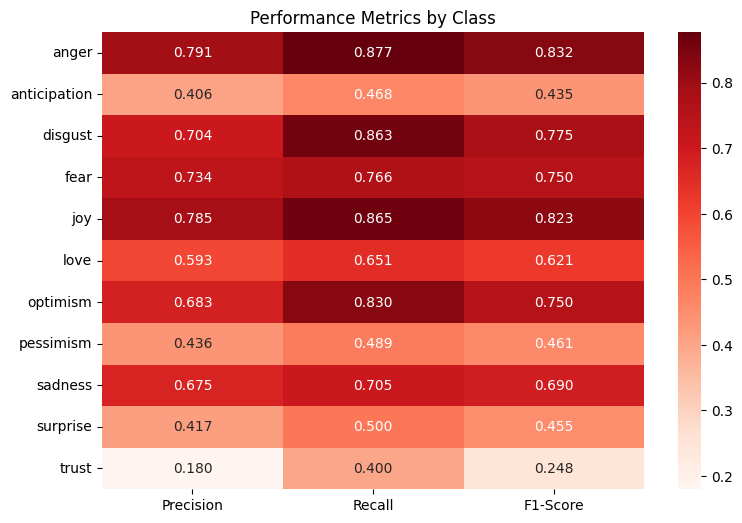

<Figure size 1200x533.333 with 0 Axes>

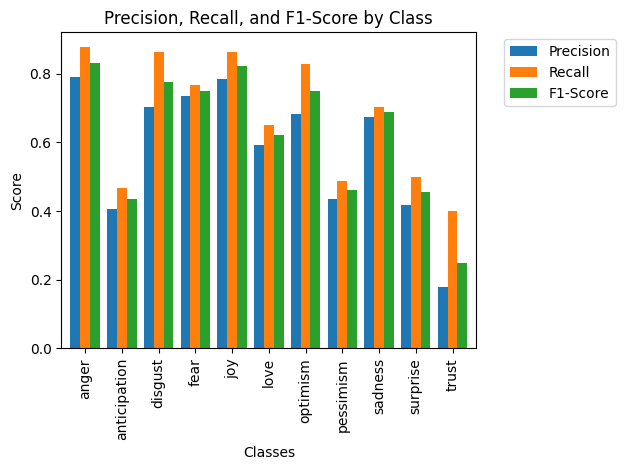

{'macro_avg': {'precision': 0.5822823069325864,
  'recall': 0.6739739342910759,
  'f1': 0.6217100450414972},
 'per_class': {'Precision': {'anger': 0.7911392405063291,
   'anticipation': 0.40625,
   'disgust': 0.7039106145251397,
   'fear': 0.7342657342657343,
   'joy': 0.7854889589905363,
   'love': 0.5934065934065934,
   'optimism': 0.6834532374100719,
   'pessimism': 0.43564356435643564,
   'sadness': 0.6751054852320675,
   'surprise': 0.4166666666666667,
   'trust': 0.1797752808988764},
  'Recall': {'anger': 0.8771929824561403,
   'anticipation': 0.46846846846846846,
   'disgust': 0.863013698630137,
   'fear': 0.7664233576642335,
   'joy': 0.8645833333333334,
   'love': 0.6506024096385542,
   'optimism': 0.8296943231441049,
   'pessimism': 0.4888888888888889,
   'sadness': 0.7048458149779736,
   'surprise': 0.5,
   'trust': 0.4},
  'F1-Score': {'anger': 0.831946755407654,
   'anticipation': 0.4351464435146444,
   'disgust': 0.7753846153846153,
   'fear': 0.75,
   'joy': 0.8231404958

In [ ]:
multilabel_evaluation(y_true = valid_labels, y_pred = valid_preds, class_names = class_names, figsize =(12,8))

<font color = 'indianred'>***Results Analysis***

<font color = 'indianred'>*Getting the best model checkpoint*

In [ ]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f'The best model checkpoint was saved at step {best_model_checkpoint_step}.')

The best model checkpoint was saved at step 600.


In [ ]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')# insert model checkpoint to the left
checkpoint

'/content/drive/MyDrive/Colab Notebooks/models/nlp_fall_2024/LLama-3.2-1B/checkpoint-600'

In [ ]:
wandb.finish()

eval/accuracy_all,▁▁▂▄▃▄▃▇▇▆▇█▇█
eval/accuracy_label,▁▄▅▇▆▇▇███████
eval/f1_macro,▁▅▆▇▇▇▇███████
eval/f1_micro,▁▄▆▇▆▇▇███████
eval/loss,█▄▂▁▁▂▁▁▁▂▃▃▂▃
eval/runtime,▂▄▃▃▃▃▄▃▁▆▃▃██
eval/samples_per_second,▇▅▆▆▆▆▅▆█▃▆▆▁▁
eval/steps_per_second,▇▅▆▆▆▆▅▆█▃▆▆▁▁
eval_accuracy,▁
eval_f1_macro,▁
eval_loss,▁


# <font color='indianred'>**7. Performing Model Inference**</font>


In [ ]:
from peft import AutoPeftModelForSequenceClassification, PeftConfig

In [ ]:
model = AutoPeftModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,
)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = '<|finetune_right_pad_id|>'

# 3. Set model to evaluation mode
model.eval()
model.config.use_cache = False
model.config.pad_token_id = tokenizer.pad_token_id
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
model.config.id2label = id2label
model.config.label2id = label2id

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config

LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "meta-llama/Llama-3.2-1B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "p

In [ ]:
# use if needed
# free_gpu_memory()

In [ ]:
custom_pipeline = pipeline(
    task = 'text-classification',
    model = model,
    tokenizer = tokenizer,
    return_all_scores = True,
    function_to_apply = 'sigmoid'
)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForS

In [ ]:
# loading in the test data
test_ds = joblib.load(data_folder/'X_test_cleaned.pkl')

In [ ]:
test_df = pd.DataFrame(test_ds).T # transposing
test_df.rename(columns = {0:'text', 1:'label'}, inplace = True)
print(test_df.head())
print("-"*30)
print(test_df.shape)
print('There are no labels for the entire test set.')

                                                text  \
0  @Adnan__786__ @AsYouNotWish Dont worry Indian ...   
1  Academy of Sciences, eschews the normally sobe...   
2                  I blew that opportunity -__- #mad   
3             This time in 2 weeks I will be 30... 😥   
4  #Deppression is real. Partners w/ #depressed p...   

                                               label  
0  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
1  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
2  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
3  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
4  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
------------------------------
(3259, 2)
There are no labels for the entire test set.


In [ ]:
# performing a test to ensure the prediction pipeline is working
sample = test_df['text'][0]

preds = custom_pipeline(sample)
preds

[[{'label': 'anger', 'score': 0.9252299070358276},
  {'label': 'anticipation', 'score': 0.20689406991004944},
  {'label': 'disgust', 'score': 0.7386690378189087},
  {'label': 'fear', 'score': 0.9674102663993835},
  {'label': 'joy', 'score': 0.031143829226493835},
  {'label': 'love', 'score': 0.0024726232513785362},
  {'label': 'optimism', 'score': 0.9207897186279297},
  {'label': 'pessimism', 'score': 0.00857748556882143},
  {'label': 'sadness', 'score': 0.0792103260755539},
  {'label': 'surprise', 'score': 7.484622619813308e-05},
  {'label': 'trust', 'score': 0.06465348601341248}]]

In [ ]:
def get_labels(pipeline_output, optimal_thresholds):
  positive_labels = []

  for pred_set in pipeline_output:
    # getting the scores for all labels
    scores = [pred['score'] for pred in pred_set]
    labels = [pred['label'] for pred in pred_set]

    # getting the positions where the score > optimal threshold
    sample_positives = [
        label for label, score, threshold in zip(labels, scores, optimal_thresholds)
        if score > threshold
    ]

    positive_labels.append(sample_positives)

  return positive_labels

In [ ]:
# paste optimal thresholds here if needed from above

In [ ]:
results = get_labels(preds, optimal_thresholds)
results

[['anger', 'disgust', 'fear', 'optimism']]

In [ ]:
def get_predictions_from_pipeline(pipeline_output, model, df_test_ids, optimal_thresholds):
    """
    This function processes the pipeline output using custom thresholds and generates predictions
    for the test dataset, returning a final DataFrame with test IDs and predicted labels.

    Parameters:
    - pipeline_output: The output from the custom pipeline (containing the scores)
    - model: The model used for generating the pipeline output (to get the id2labels)
    - df_test_ids: A DataFrame containing the test IDs
    - optimal_thresholds: A list of optimal thresholds for each label

    Returns:
    - df_pred_final: A pandas DataFrame with test IDs and their corresponding label predictions in binary format
    - positive_labels_list: A list of positive labels for each instance to compare results.
    """
    # 1. Get positive labels using the custom thresholds
    positive_labels_list = get_labels(pipeline_output, optimal_thresholds)

    # 2. Prepare binary predictions using the optimal thresholds
    binary_predictions = []
    for pred_set in pipeline_output:
        scores = [pred['score'] for pred in pred_set]
        binary_preds = [1 if score > threshold else 0 for score, threshold in zip(scores, optimal_thresholds)]
        binary_predictions.append(binary_preds)

    # 3. Convert the binary predictions to a DataFrame
    # Map the model config labels
    class_labels = [model.config.id2label[i] for i in range(len(model.config.id2label))]
    df_predictions = pd.DataFrame(binary_predictions, columns=class_labels)

    # 4. Concatenate test IDs with predictions
    df_pred_final = pd.concat([df_test_ids.reset_index(drop=True), df_predictions], axis=1)

    # 5. Set the index of the final DataFrame to be the ID column
    df_pred_final = df_pred_final.set_index('ID')

    return df_pred_final, positive_labels_list


In [ ]:
test_ids = joblib.load(data_folder/'test_ids.pkl')
test_ids.head()

,ID
0,2018-01559
1,2018-03739
2,2018-00385
3,2018-03001
4,2018-01988


<font color = 'indianred'>***Prepping the test_df to make predictions***





In [ ]:
test_ds = test_df.drop(columns = {'label'}) # dropping the missing labels from the test dataset

In [ ]:
test_ds

,text
0,@Adnan__786__ @AsYouNotWish Dont worry Indian ...
1,"Academy of Sciences, eschews the normally sobe..."
2,I blew that opportunity -__- #mad
3,This time in 2 weeks I will be 30... 😥
4,#Deppression is real. Partners w/ #depressed p...
...,...
3254,shaft abrasions from panties merely shifted to...
3255,@lomadia heard of Remothered? Indie horror gam...
3256,All this fake outrage. Y'all need to stop 🤣
3257,Would be ever so grateful if you could record ...


In [ ]:
test_ds = Dataset.from_pandas(test_ds)

In [ ]:
test_ds['text'][0:3]

['@Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell',
 'Academy of Sciences, eschews the normally sober tone of scientific papers and calls the massive loss of wildlife a “biological annihilation',
 'I blew that opportunity -__- #mad']

In [ ]:
# input for the function written above
pipeline_output = custom_pipeline(test_ds['text'][:]) # running the prediction pipeline on all documents

In [ ]:
df_pred_final, positive_labels_list = get_predictions_from_pipeline(pipeline_output = pipeline_output,
                                                                    model = model,
                                                                    df_test_ids = test_ids, optimal_thresholds = optimal_thresholds)

In [ ]:
df_pred_final.sum()

,0
anger,1150
anticipation,478
disgust,1367
fear,482
joy,1576
love,555
optimism,1357
pessimism,418
sadness,1030
surprise,195


In [ ]:
df_pred_final.shape

(3259, 11)

In [ ]:
df_pred_final.to_csv(base_folder/'final_predictions_llama_3.2_1B.csv')